# Investigating the relationship between dollar signs and review trends

## Importing packages

In [1]:
#import the python scientific suite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import sklearn
import seaborn as sns
import scipy
import pylab
import statsmodels

from sklearn.cross_validation import *
from sklearn import svm, linear_model
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree

from textblob import TextBlob

import statsmodels.api as sm
from collections import defaultdict

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
#plot figures inline in Jupyter notebooks
%matplotlib inline 

#use seaborn for plotting
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')
pylab.rcParams.update({'figure.autolayout': True})

In [3]:
def WordCount(corpus, keywords):
    count = 0 #start the counter at 0
    upper_words = [w.upper() for w in keywords]
    
    for word in corpus.split(): #for each word in the corpus
        if word.upper() in upper_words: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count

def WordFreq(corpus, keywords):
    count = 0 #start the counter at 0
    upper_words = [w.upper() for w in keywords]
    
    for word in corpus.split(): #for each word in the corpus
        if word.upper() in upper_words: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count/len(corpus.split())

def Polarity(corpus):
    blob = TextBlob(unicode(corpus, 'utf-8'))
    return blob.sentiment.polarity

def Subjectivity(corpus):
    blob = TextBlob(unicode(corpus, 'utf-8'))
    return blob.sentiment.subjectivity

#define some helper functions 
def CountInstance(df, col_name):

    name, counts = np.unique(df[col_name], return_counts = True)
    counts_df = pd.DataFrame(data = {col_name: name, ('n_'+ col_name):counts})
    merged_df = pd.merge(df, counts_df, on = col_name, how = 'left')
    
    return(merged_df)
def BootstrapDataframe(df):
    resample_i = np.floor(np.random.rand(len(df))*len(df)).astype(int)
    return(df.iloc[resample_i])


def TopChains(df, cutoff):
    #
    # Find the top chains
    # include a dataframe with column 'name'
    
    name, counts = np.unique(df['name'], return_counts = True)
    counts_df = pd.DataFrame(data = {'name': name, 'counts':counts})
    top_chains = counts_df.sort_values(by = 'counts', ascending = False)
    top_chains.index = range(len(top_chains)) #re-index
    
    return list(top_chains['name'][top_chains['counts'] > cutoff])

def OrderName(df, order_col, order_on):

    ordr = [] #median
    nme = [] #name

    for name in (np.unique(df[order_col])):
        nme.append(name)
        ordr.append(np.mean(df[df[order_col] == name][order_on].dropna()))

    order = list(pd.DataFrame([nme,ordr]).T.sort_values(by = 1)[0])
    
    return(order)

def RollingGaussianMean(df, x, y, centers, eps):
    df = df.dropna()
    rolling = [] #start a list to hold the rolling mean
    for bc in centers: #for each bin center in the list of bin centers
            w = scipy.stats.norm.pdf((df[x] - bc)/(eps))
            if sum(w) != 0.0:
                rolling.append((bc, np.average(df[y], weights = w))) #take the mean and add it to the stack
            else:
                rolling.append((bc, np.average(df[y])))
    return(pd.DataFrame(rolling).rename(columns = {0: 'x', 1: 'y'}))
def train_and_evaluate(clf, X_train, y_train, verbose = False):
        
    clf.fit(X_train, y_train) #fit the model

    #create a k-fold cross validation iterator of k = 5 folds

    cv = KFold(X_train.shape[0], 5, shuffle = True)
    scores = cross_val_score(clf, X_train, y_train, cv = cv)

    if verbose == True: #if we want to print status
        print("Coefficient of determination on training set:", clf.score(X_train, y_train))
        print("Average coefficient of determination using 5-fold crossvalidation:", np.mean(scores))
    
    return clf.score(X_train, y_train), np.mean(scores)

def OneDimensionalROC(clf, X_train, y_train, X_test):
    
    pylab.rcParams['figure.figsize'] = (6.0, 6.0)
    
    #debate differences between decision function and predict_proba?
    #they are inverse monotone
    
    #y_score = clf.fit(X_train, y_train).decision_function(X_test)
    y_score = clf.fit(X_train, y_train).predict_proba(X_test).T[1]

    n_classes = 1 #this is a single class classification problem

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc, y_score
def SelectMultipleWLS(df, y_col, x_col, id_list, id_name, name, fdr = 0.1):
    
    fit_params = defaultdict(list)

    for ids in id_list: #for the unique business IDs, i.e. for each neighborhood
        
        f = df[df[id_name] == ids][[x_col,y_col]] #create a review dataframe that is just for that neighborhood
        wls = sm.WLS(f[y_col], sm.add_constant(f[x_col])).fit()
        
        fit_params[id_name].append(ids)
        fit_params[name + '_slope'].append(wls.params[x_col])
        fit_params[name + '_p_value'].append(wls.pvalues[x_col])
        fit_params[name + '_slope_err'].append(wls.bse[x_col])
        fit_params[name + '_mean'].append(np.mean(f[y_col]))
    
    fit_params = pd.DataFrame(fit_params)

    fit_params[name + '_c_hyp'], fit_params[name + '_c_pvals'], _ , _, = statsmodels.sandbox.stats.multicomp.multipletests(fit_params[name + '_p_value'],\
                                                  method = 'fdr_bh', alpha = fdr)
        
    return fit_params

def InCategory(string_list, string):
    if string in string_list:
        out = 1
    else:
        out = 0
    return out

## Reading in the files:

In [4]:
#read in the data from the files
file_dir = '/Users/zihaoxu/Desktop/Pomona/2017_Spring/Data Science Research/yz_data/' #replace this with the path to your data files

f = {'R': 'R_review_stat.csv', 'T': 'T_review_text.csv', 'N': 'N_neighborhood.csv',\
    'B': 'B_business_2.csv', 'U': 'U_user.csv'}

d = defaultdict() #initialize an empty dictionary to hold the dataframes

for fi in f: #for each file in the dictinary of files
    d[fi] = pd.read_csv(file_dir + f[fi]) #read in the files and hold them in the dataframe dictionary

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(d.keys()) #the list of files in the data dictionary

dict_keys(['U', 'N', 'T', 'R', 'B'])


In [6]:
#begin filtration of data based on multiple criteria
min_reviews_per_business = 3
min_reviews_per_user = 5
min_business_per_neighborhood = 20

#perform the filtration by updating the dataframes
d['B'] = d['B'][(d['B']['review_count'] >= min_reviews_per_business)]
d['U'] = d['U'][(d['U']['n_reviews'] >= min_reviews_per_user)]
d['N'] = d['N'][(d['N']['n'] >= min_business_per_neighborhood)]

# Visualizing the review trend

In [56]:
d['RB'] = pd.merge(d['R'], d['B'][['business_id', 'Price']], on = ['business_id'])
d['NRB'] = pd.merge(d['RB'], d['N'][['n','z_hood']], on = ['z_hood'], how = 'left').dropna()

In [57]:
price_list = [1.0, 2.0, 3.0, 4.0]
for price in price_list:
    print("Number of restaurants w/ ", str(price), "dollar signs: ", str(len(d['NRB'][d['NRB']['Price']==price])))

Number of restaurants w/  1.0 dollar signs:  200585
Number of restaurants w/  2.0 dollar signs:  440310
Number of restaurants w/  3.0 dollar signs:  53781
Number of restaurants w/  4.0 dollar signs:  6533


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


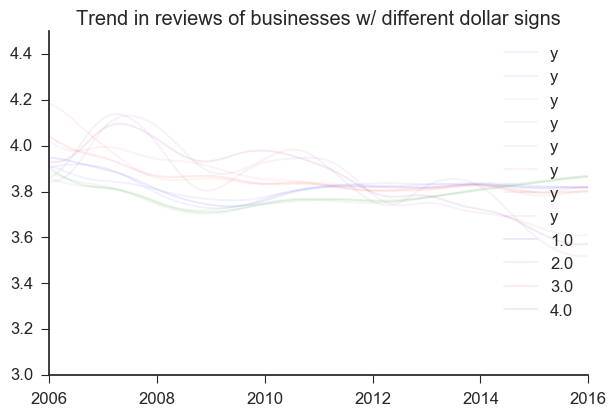

In [59]:
color_list = ['blue', 'g','r','purple'] # color of each dollar sign
n_samples = 2

# visualize the mean review trend of restaurants within each dollar binns
for price in price_list:
    rr = d['NRB'][d['NRB']['Price']==price]
    for _ in range(n_samples):
        n_r = BootstrapDataframe(rr)
        n_gm = RollingGaussianMean(n_r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
        #plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
        plt.plot(n_gm['x'], n_gm['y'], c = color_list[price_list.index(price)], alpha= 0.05)
    

for price in price_list:
    r = d['NRB'][d['NRB']['Price']==price]
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
    plt.plot(gm['x'], gm['y'], c = color_list[price_list.index(price)], label = price, alpha= 0.085)

plt.ylim(3.,4.5)     
plt.title("Trend in reviews of businesses w/ different dollar signs")
plt.legend()
sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/new.png', dpi = 300, fmt = 'png')
    

# Analyzing the distribution

In [72]:
yelp_wls = d['RB'][['z_hood']]

In [73]:
#yelp_wls = SelectMultipleWLS(d['RB'], 'stars', 'year', cor_hoods, 'z_hood', 'all_yelp')
price_list = ['1.0', '2.0', '3.0', '4.0']

for price in price_list:
    d['RB'][price] = d['RB']['Price'].astype('str').apply(InCategory, args = (price,))
    d['CRB'] = d['RB'][d['RB'][price] == 1]
    yelp_wls = pd.merge(SelectMultipleWLS(d['CRB'], 'stars', 'year', np.unique(d['CRB']['z_hood']), 'z_hood', price), yelp_wls,\
                   on = 'z_hood', how = 'outer')

yelp_wls = yelp_wls.drop([col for col in yelp_wls.columns if '_pval' in col], axis = 1)
nzy = pd.merge(d['N'], yelp_wls, on = 'z_hood').drop(['Unnamed: 0'], axis = 1).drop_duplicates()

number of data points for:  1.0 dollar sign 41
number of data points for:  2.0 dollar sign 55
number of data points for:  3.0 dollar sign 12
number of data points for:  4.0 dollar sign 8


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


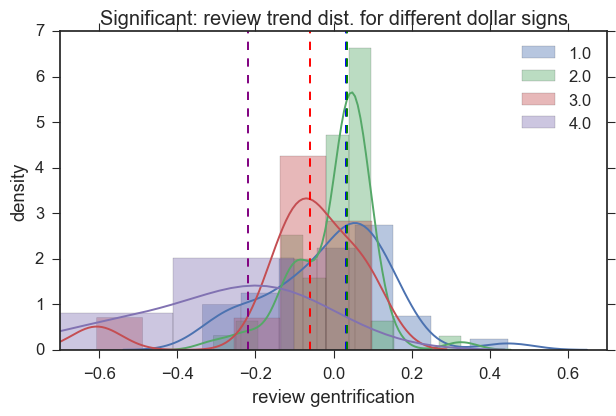

In [78]:
for price in price_list:
    #temp = nnzy[nnzy[price+'_c_hyp']==True] 
    temp = nzy[nzy[price+'_c_hyp']==True] 
    print('number of data points for: ', str(price), 'dollar sign', str(len(np.unique(temp['z_hood']))))
    sns.distplot(temp[price+'_slope'].dropna(), label = price)
    plt.axvline(np.median(temp[price+'_slope'].dropna()), linestyle = 'dashed', c = color_list[price_list.index(price)])

plt.xlim(-.7,.7)
plt.title('Significant: review trend dist. for different dollar signs')
plt.xlabel('review gentrification')
plt.ylabel('density')
plt.savefig('/Users/zihaoxu/Desktop/Significant: review trend dist.png', dpi = 300, fmt = 'png')
plt.legend()

number of data poitns:  192


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


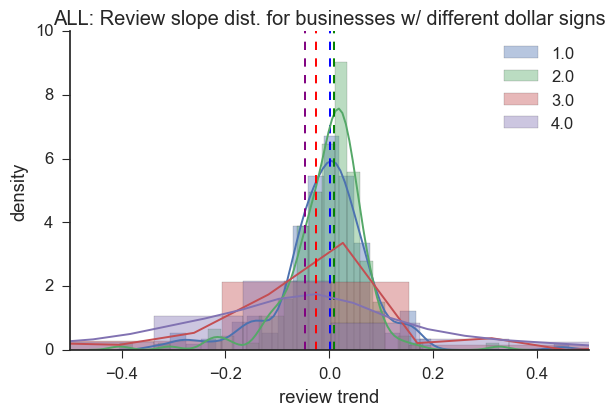

In [81]:
print ("number of data poitns: ", len(nzy))
for price in price_list:
    sns.distplot(nzy[price+'_slope'].dropna(), label = price)
    plt.axvline(np.median(nzy[price+'_slope'].dropna()), linestyle = 'dashed', c = color_list[price_list.index(price)])

plt.xlim(-.5,.5)
plt.title('ALL: Review slope dist. for businesses w/ different dollar signs')
plt.xlabel('review trend')
plt.ylabel('density')
plt.legend()
sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/ALL:Gentrification dist.png', dpi = 300, fmt = 'png')



In [97]:
# Creating a new data frame
d['DS'] = defaultdict(list)

for neighborhood in np.unique(nzy['z_hood']):
    d['DS']['z_hood'] += 4 * [neighborhood]
    temp = d['RB'][d['RB']['z_hood']==neighborhood]
    for price in price_list:
        d['DS']['price'].append(float(price))
        d['DS']['slope'].append(float(nzy[nzy['z_hood']==neighborhood][price+'_slope']))
        n_temp = temp[temp['Price']==float(price)]
        d['DS']['n'].append(len(np.unique(n_temp['business_id'])))
        d['DS']['n_review'].append(len(temp[temp['Price']==float(price)]))
        d['DS']['c_hyp'].append(float(nzy[nzy['z_hood']==neighborhood][price+'_c_hyp']))

d['DS'] = pd.DataFrame(d['DS']).dropna()

In [151]:

mrm = linear_model.LinearRegression()
n_mrm = linear_model.LinearRegression()

df = d['DS'][d['DS']['c_hyp']==1.]
df = df[df['slope']>-2.]

n_mrm.fit(df['n'].reshape(len(df['n']),1), df['slope'].reshape(len(df['slope']),1))
mrm.fit(df['price'].reshape(len(df['price']),1), df['slope'].reshape(len(df['slope']),1))


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

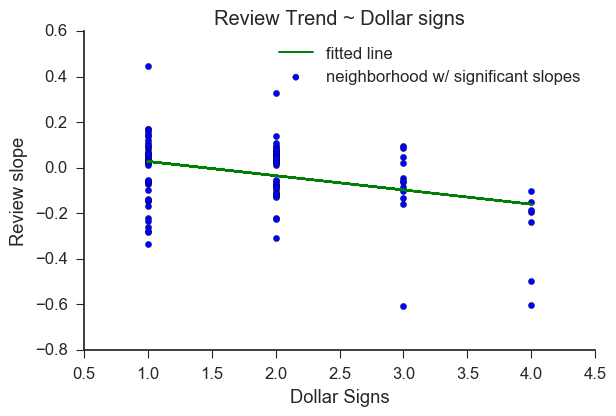

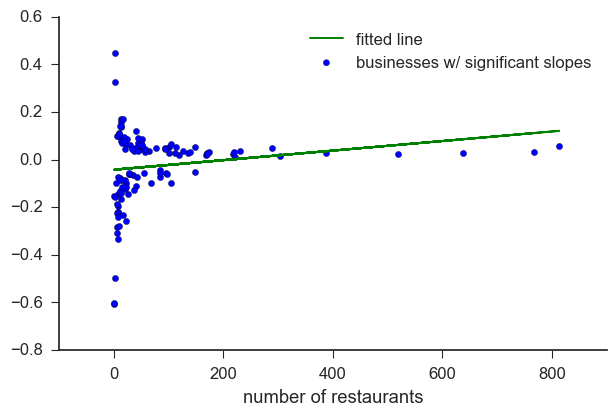

In [152]:

#plt.scatter(d['DS']['price'], d['DS']['slope'], c = 'r', alpha = .6, label = 'all')
plt.scatter(df['price'], df['slope'], c = 'b', label = 'neighborhood w/ significant slopes')
plt.plot(df['price'], mrm.predict(df['price'].reshape(len(df['price']),1)), c = 'green', label = 'fitted line')
plt.legend()
plt.title('Review Trend ~ Dollar signs')
plt.xlabel('Dollar Signs')
plt.ylabel('Review slope')
sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/regression_on_DS.png', dpi = 300, fmt = 'png')



plt.figure()
#plt.scatter(d['DS']['n'], d['DS']['slope'], c = 'r', alpha = .6, label = 'all')
plt.scatter(df['n'], df['slope'], c = 'b', label = 'businesses w/ significant slopes')
plt.plot(df['n'], n_mrm.predict(df['n'].reshape(len(df['price']),1)), c = 'green', label = 'fitted line')
plt.xlabel('number of restaurants')
plt.legend()
sns.despine()

In [153]:
len(df)

115

In [156]:
#c_features = df[['n', 'price']]
c_null = pd.DataFrame(np.ones(len(c_features)))
#c_null = df[['n']]
#c_response = df[['slope']]
c_response = df[['price']]
c_features = df[['slope']]

In [164]:
std_errors = defaultdict(list)
#models = {'LASSO': linear_model.Lasso(alpha = 0.000001), 'RF':RandomForestRegressor(), 'Linear': linear_model.LinearRegression()}
sim_num = 1000

#for model in models
for i in range(sim_num):
    
    X_train, X_test, y_train, y_test = train_test_split(c_features, c_response, test_size = 0.50)
    nX_train, nX_test, ny_train, ny_test = train_test_split(c_null, c_response, test_size = 0.50)

    #choose which kind of model to use
    
    #mrm = RandomForestRegressor() #mean rent model
    #n_mrm = RandomForestRegressor() #null mean rent model

    mrm = linear_model.LinearRegression()
    n_mrm = linear_model.LinearRegression()
    
    #mrm = svm.SVC()
    #n_mrm = svm.SVC()

    #train the model
    train_and_evaluate(mrm, X_train, np.ravel(y_train), verbose = False) #train the model on the data
    train_and_evaluate(n_mrm, nX_train, np.ravel(ny_train), verbose = False) #train the model on the data
    
    #append the standard error to the list
    std_errors['dollar_sign'].append(np.std(np.array(mrm.predict(X_test)) - y_test['price']))
    std_errors['null'].append(np.std(np.array(n_mrm.predict(nX_test)) - ny_test['price']))


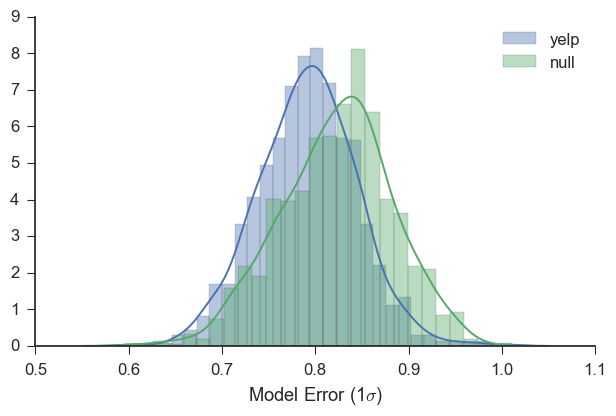

In [165]:
#plot the error distributions
sns.distplot(std_errors['dollar_sign'], label = 'yelp') #with the yelp features
sns.distplot(std_errors['null'], label = 'null') #just the dummies
plt.xlabel('Model Error (1$\sigma$)')
plt.legend()
sns.despine()

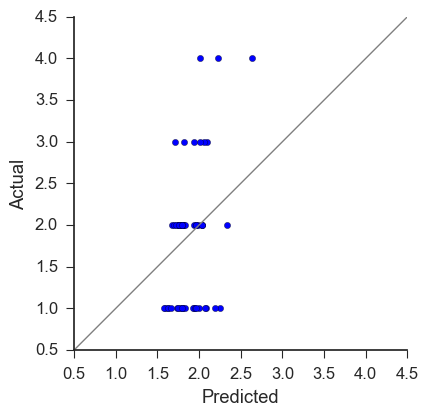

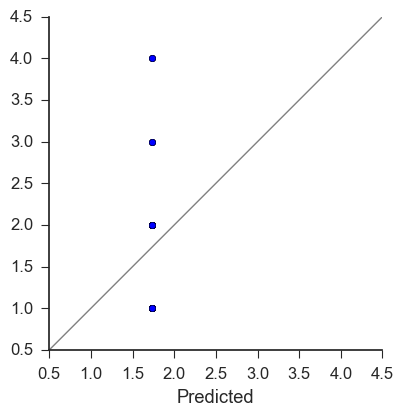

In [168]:

plt.figure()
plt.scatter(mrm.predict(X_test), y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot([.5,4.5], [.5,4.5], lw = 1, c = 'grey')
plt.xlim(.5,4.5)
plt.ylim(.5,4.5)
plt.gca().set_aspect('equal')
sns.despine()

plt.figure()
plt.scatter(n_mrm.predict(nX_test), ny_test)
plt.xlabel('Predicted')
plt.plot([.5,4.5], [.5,4.5], lw = 1, c = 'grey')
plt.xlim(.5,4.5)
plt.ylim(.5,4.5)
plt.gca().set_aspect('equal')
sns.despine()